In [19]:
# For Kaggle

# Standard Libraries
import sys
import os
import collections

# Data Science Libraries
import pandas as pd
import numpy as np
import optuna

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Statistics Libraries
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg

# ML Libraries
import sklearn as sk
import lightgbm
import xgboost
import catboost

# Project Libraries
#import optiver2023

# Configure Visualization
%matplotlib inline
plt.style.use('bmh')

# Configure Pandas and SKLearn
pd.set_option("display.max_colwidth", 20)
pd.set_option("display.precision", 3)
sk.set_config(display="diagram")

# File Specific Configurations
plt.rcParams['figure.dpi'] = 270
START = pd.Timestamp.now()
SEED = 42

In [2]:
def inspect_columns(df):
    # A helper function that does a better job than df.info() and df.describe()
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

def time_series_plot(df, cols, stock_id, date_id):
    # A helper function to plot the time seires for a given stock in a given date
    (df
        .query(f'stock_id == {stock_id} & date_id == {date_id}')
        .loc[:, ['seconds_in_bucket'] + cols]
        # .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(5, 2), linewidth=1)
    )

<font face = 'STCAIYUN'><h1>1. Data Description

In [3]:
Xy_train = pd.read_csv("train.csv")
Xy_train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.181e+06,1,1.000,1.338e+07,NaN,NaN,1.000,60651.50,1.000,8493.03,1.000,-3.030,0,0_0_0
1,1,0,0,1.666e+05,-1,1.000,1.642e+06,NaN,NaN,1.000,3233.04,1.001,20605.09,1.000,-5.520,0,0_0_1
2,2,0,0,3.029e+05,-1,1.000,1.819e+06,NaN,NaN,0.999,37956.00,1.000,18995.00,1.000,-8.390,0,0_0_2
3,3,0,0,1.192e+07,-1,1.000,1.839e+07,NaN,NaN,1.000,2324.90,1.000,479032.40,1.000,-4.010,0,0_0_3
4,4,0,0,4.475e+05,-1,1.000,1.786e+07,NaN,NaN,0.999,16485.54,1.000,434.10,1.000,-7.350,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2.441e+06,-1,1.000,2.828e+07,1.000,1.000,1.000,32257.04,1.000,319862.40,1.000,2.310,26454,480_540_195
5237976,196,480,540,3.495e+05,-1,1.001,9.188e+06,1.000,1.000,1.001,205108.40,1.001,93393.07,1.001,-8.220,26454,480_540_196
5237977,197,480,540,0.000e+00,0,0.996,1.273e+07,0.996,0.996,0.996,16790.66,0.996,180038.32,0.996,1.169,26454,480_540_197
5237978,198,480,540,1.001e+06,1,0.999,9.477e+07,0.999,0.999,0.999,125631.72,0.999,669893.00,0.999,-1.540,26454,480_540_198


In [4]:
inspect_columns(Xy_train)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,73,199,int64
date_id,False,481,False,0.00,0,408,480,int64
seconds_in_bucket,False,55,False,0.00,0,270,540,int64
imbalance_size,False,2971863,True,0.00,3180602.69,1141722.12,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,-1,-1,int64
reference_price,False,28741,True,0.00,1.0,0.999,1.002,float64
matched_size,False,2948862,True,0.00,13380276.64,6992964.63,24073677.32,float64
far_price,False,95739,True,55.26,NaN,NaN,1.001,float64
near_price,False,84625,True,54.55,NaN,NaN,1.001,float64
bid_price,False,28313,True,0.00,1.0,0.999,1.002,float64


<font color = 'red'>(1) 股票代码与时间<font color = 'black'>\
stock_id, date_id, seconds_in_bucket分别为股票代码、日期、日内时间\
seconds_in_bucket在其余两项给定时无部分缺失情况\
可以得出出现缺失的stock_id, date_id\
time_id为根据date_id和seconds_in_bucket的时序排列

In [5]:
# Let's first exam if all the time series are 55 steps long
(Xy_train
    .groupby(['stock_id', 'date_id'])
    ['seconds_in_bucket'] # Extract the column of interest
    .count() # Count the number of rows in each permutation of stock_id and date_id
    .apply(lambda x: x == 55) # Check if every count is 55
    .all() # Check if all the booleans are True
)

True

In [6]:
# Get all the stock_id and date_id
all_stock_id = np.sort(Xy_train["stock_id"].unique())
print(all_stock_id[:10])
print(all_stock_id[-10:])
print(f'length of stock_id: {len(all_stock_id)}')
all_date_id = np.sort(Xy_train["date_id"].unique())
print(all_date_id[:10])
print(all_date_id[-10:])
print(f'length of date_id: {len(all_date_id)}')

# Make a MultiIndex object from the cartesian product of all possible combinations.
multi_index = pd.MultiIndex.from_product(
    iterables=[all_date_id, all_stock_id], 
    names=["date_id", "stock_id"]
)

# To get the all missing data.
# join the MultiIndex with the Trianing data,
# and then filter out all the rows that are not in the training data.
missing_data = (Xy_train
    .loc[:, ["date_id", "stock_id"]]
    .assign(in_train=True) # Add a new column to indicate if the row is in the training data
    .set_index(["date_id", "stock_id"])
    .merge(multi_index.to_frame(), how="right", left_index=True, right_index=True)
    .query("in_train.isna()") # Filter out the missing data
    .set_index("stock_id", drop=True)
    ["date_id"]
)

# A Series object for missing data
missing_data

[0 1 2 3 4 5 6 7 8 9]
[190 191 192 193 194 195 196 197 198 199]
length of stock_id: 200
[0 1 2 3 4 5 6 7 8 9]
[471 472 473 474 475 476 477 478 479 480]
length of date_id: 481


stock_id
69       0
78       0
79       0
102      0
135      0
      ... 
102    291
102    292
102    293
102    294
73     320
Name: date_id, Length: 964, dtype: int64

In [7]:
# Show all the stock_id that have at least 1 day of missing data
missing_data.index.unique()

Index([69, 78, 79, 102, 135, 150, 153, 156, 199, 99, 73], dtype='int64', name='stock_id')

In [8]:
# See which date's data are missing for a specific stock_id
stock_id = 78 # change this
missing_data[stock_id]

stock_id
78    0
78    1
78    2
78    3
Name: date_id, dtype: int64

In [9]:
# A summary of the of missing date counts for each stock_id
missing_data.groupby("stock_id").count().sort_values()

stock_id
73       1
99       1
78       4
69      37
156     37
150     59
153     70
199     88
79     181
135    191
102    295
Name: date_id, dtype: int64

In [10]:
# time_id can be calculated by date_id and seconds_in_bucket
((55*Xy_train['date_id']+Xy_train['seconds_in_bucket']/10) == Xy_train['time_id']).all()

True

<font color = 'red'>(2) order book 数据<font color = 'black'>\
bid_price, ask_price, wap极少量数据为nan，且只在同一天内一起全部为nan\
bid, ask数据均为一档price和size\
wap = (bid_price\*ask_size + ask_price\*bid_size) / (bid_size + ask_size)\
可以理解为全部一档挂单按照对手价格成交的平均成交价

In [11]:
# The bid_price, ask_price and wap are nans at the same time

print(len(Xy_train[Xy_train['bid_price'].isna()]))
print(len(Xy_train[Xy_train['ask_price'].isna()]))
print(len(Xy_train[Xy_train['wap'].isna()]))
print(len(Xy_train[Xy_train['bid_price'].isna() & Xy_train['ask_price'].isna() & Xy_train['wap'].isna()]))

# The time they are nans are within a whole day

print(Xy_train
    .groupby(['stock_id','date_id'])
    ['seconds_in_bucket']
    .count()
    .apply(lambda x:x==55)
    .all())

220
220
220
220
True


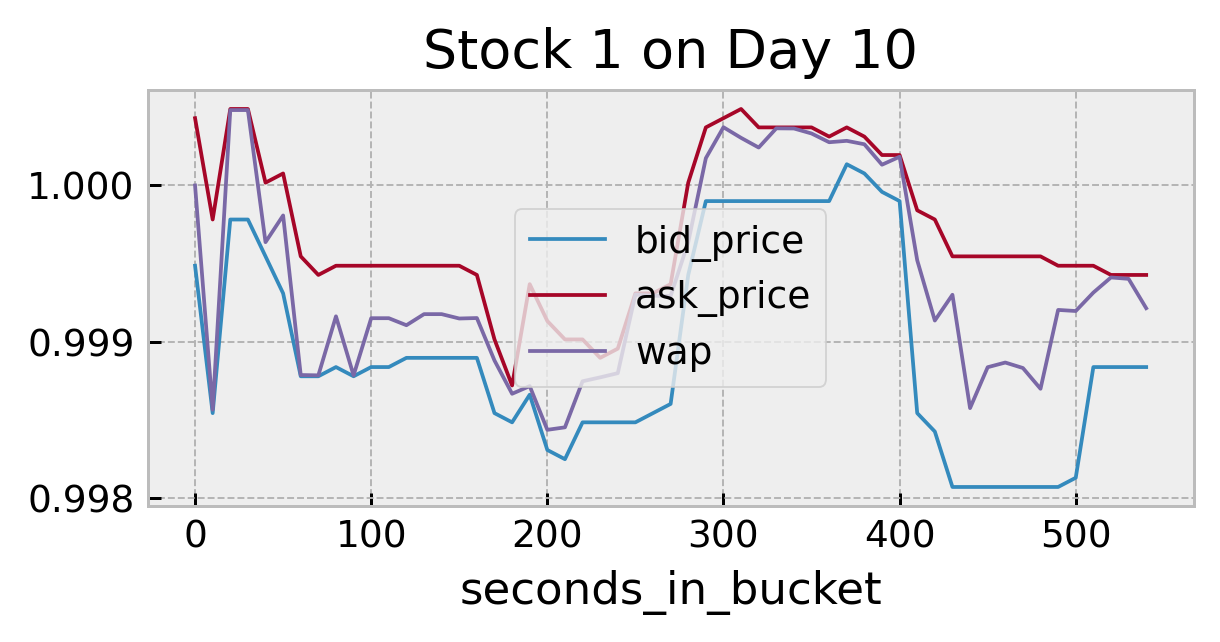

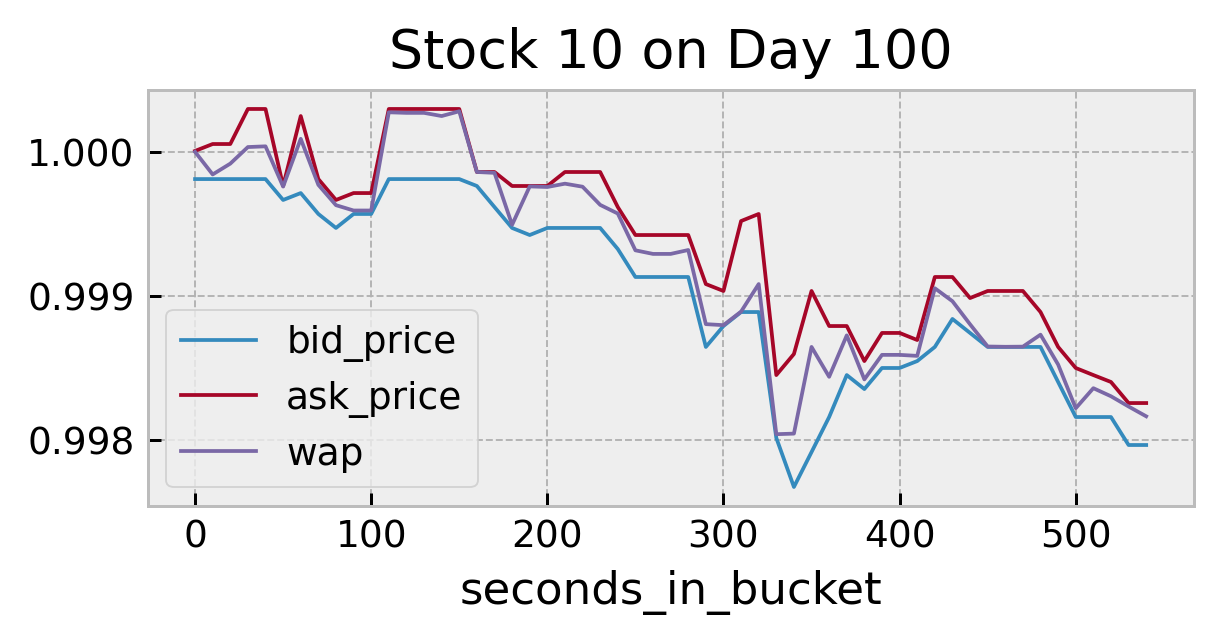

In [12]:
# We tried a few different stock_id and date_id to see the common patterns

time_series_plot(
    df=Xy_train, 
    cols=['bid_price','ask_price', 'wap'], 
    stock_id = 1,
    date_id = 10
)

# Another example

time_series_plot(
    df=Xy_train, 
    cols=['bid_price','ask_price', 'wap'], 
    stock_id = 10,
    date_id = 100
)

<font color = 'red'>(3) auction order book 数据<font color = 'black'>\
far_price is the price maximizes the matched_size\
imbalance_size is the orders left at far_price and has a direction of imbanalnce_buy_sell_flag\

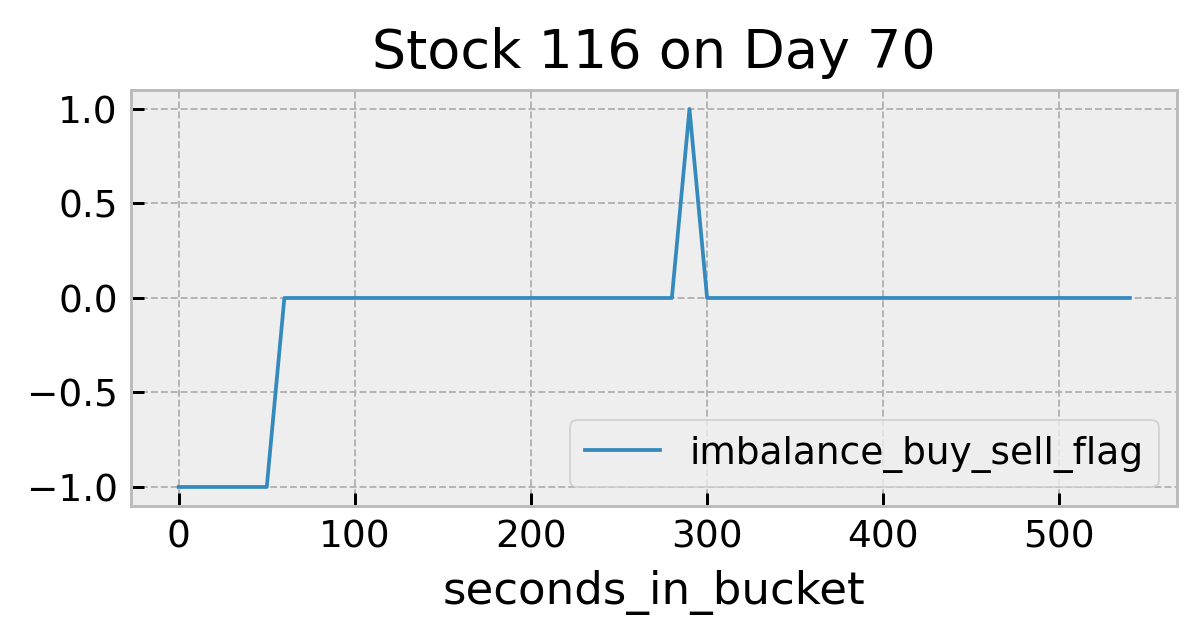

In [14]:
# To see different random stock_id and date_id, simply run the cell again
time_series_plot(
    df=Xy_train, 
    cols=['imbalance_buy_sell_flag'], 
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)


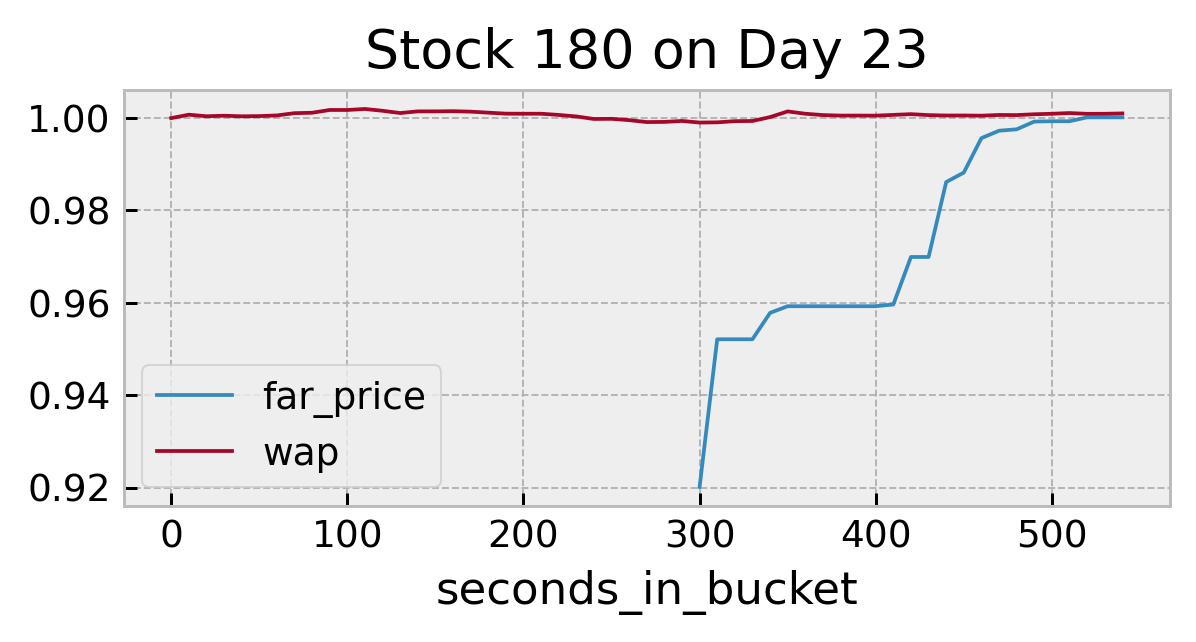

In [15]:
# Compare the far_price and wap
time_series_plot(
    df=Xy_train, 
    cols=['far_price', 'wap'],
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

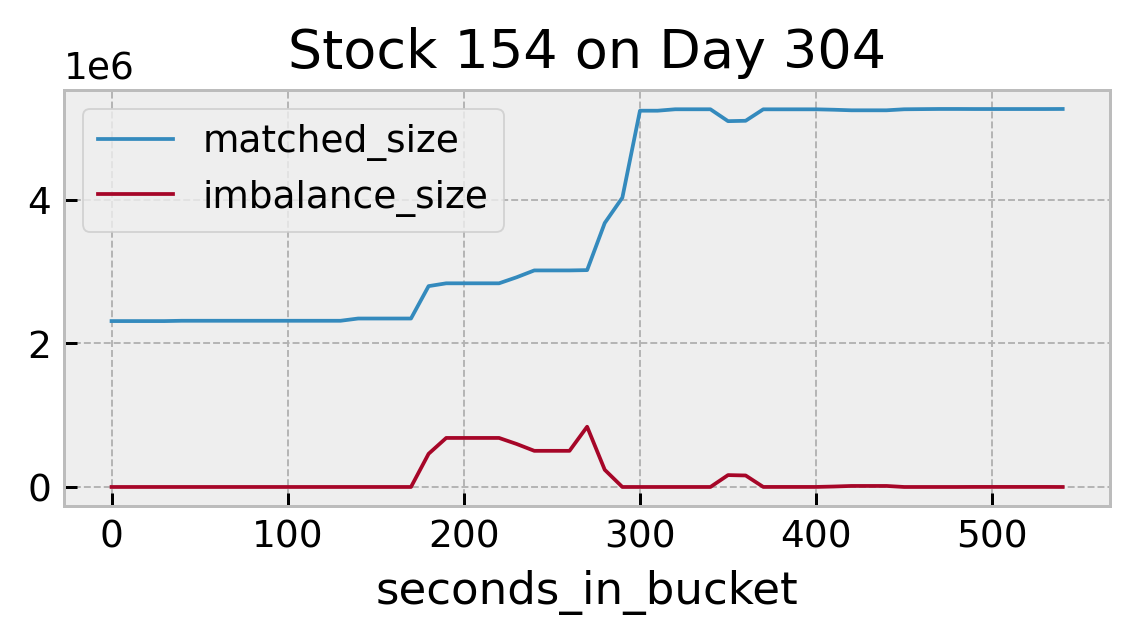

In [16]:
# Compare the matched_size and imbalance_size
time_series_plot(
    df=Xy_train, 
    cols=['matched_size', 'imbalance_size'], 
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

<font color = 'red'>(4) combined order book 数据<font color = 'black'>\
near_price is the far_price in the combined order book\
reference_price is the near_price between best bid and best ask

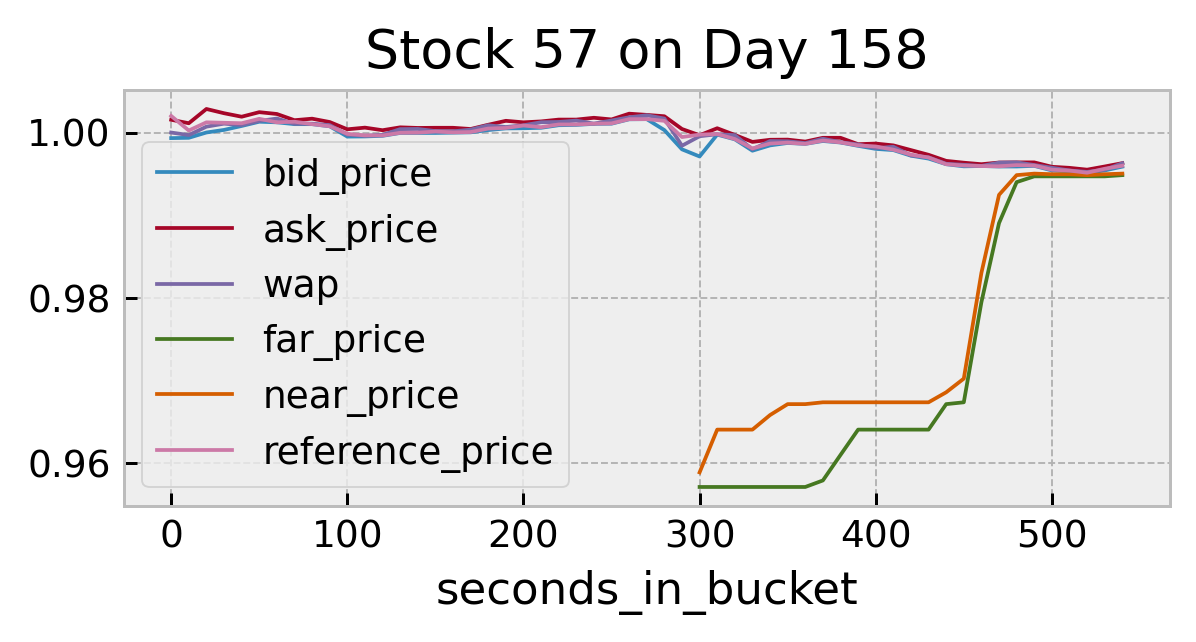

In [17]:
time_series_plot(
    df=Xy_train, 
    cols=['bid_price', 'ask_price', 'wap', 'far_price', 'near_price', 'reference_price'], 
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

<font face = 'STCAIYUN'><h1>2. Base Models

<font color = 'red'>(1) lightgbm<font color = 'black'>

In [29]:
# direct lightgbm

X = Xy_train.query("target.notna()").drop(['row_id', "time_id"], axis=1)
y = X.pop("target")

model_0 = lightgbm.LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample_for_bin=200000, 
    objective='mae', 
    class_weight=None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=SEED, 
    n_jobs=-1, 
    importance_type='split',
    force_row_wise=True
)

fold_predictions  = []
val_scores = []

splitter = sk.model_selection.TimeSeriesSplit(5).split(X, y)

for fold, (train_index, val_index) in enumerate(splitter):
    print(f"Fold {fold + 1}")
    model = sk.base.clone(model_0)

    # Define train and val set
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    fold_predictions.append((val_index, y_pred))
    val_scores.append(sk.metrics.mean_squared_error(y_pred, y_val, squared=False))

print(f'Basic RMSE score: {sk.metrics.mean_squared_error(np.zeros(len(y)), y, squared=False)}')
print(f'val_scores: {val_scores}')
print(f'Average RMSE across folds: {np.mean(val_scores)}')
print(f'Standard error of RMSE across folds: {np.std(val_scores)}')

Fold 1
[LightGBM] [Info] Total Bins 2887
[LightGBM] [Info] Number of data points in the train set: 872982, number of used features: 14
[LightGBM] [Info] Start training from score -0.029802
Fold 2
[LightGBM] [Info] Total Bins 2968
[LightGBM] [Info] Number of data points in the train set: 1745964, number of used features: 14
[LightGBM] [Info] Start training from score -0.069737
Fold 3
[LightGBM] [Info] Total Bins 3050
[LightGBM] [Info] Number of data points in the train set: 2618946, number of used features: 14
[LightGBM] [Info] Start training from score -0.079870
Fold 4
[LightGBM] [Info] Total Bins 3054
[LightGBM] [Info] Number of data points in the train set: 3491928, number of used features: 14
[LightGBM] [Info] Start training from score -0.050068
Fold 5
[LightGBM] [Info] Total Bins 3054
[LightGBM] [Info] Number of data points in the train set: 4364910, number of used features: 14
[LightGBM] [Info] Start training from score -0.069737
Basic RMSE score: 9.452978433805399
val_scores: [10

<font color = 'red'>(2) xgboost<font color = 'black'>

In [34]:
# direct xgboost

X = Xy_train.query("target.notna()").drop(['row_id', "time_id"], axis=1)
y = X.pop("target")

model_0 = xgboost.XGBRegressor(
    objective='reg:squarederror',  # 回归任务
    learning_rate=0.1,               # 学习率
    max_depth=5,                     # 树的最大深度
    n_estimators=100,                # 迭代次数
    alpha=10,                        # L1 正则化
    random_state=SEED                  # 随机种子
)

fold_predictions  = []
val_scores = []

splitter = sk.model_selection.TimeSeriesSplit(5).split(X, y)

for fold, (train_index, val_index) in enumerate(splitter):
    print(f"Fold {fold + 1}")
    model = sk.base.clone(model_0)

    # Define train and val set
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    fold_predictions.append((val_index, y_pred))
    val_scores.append(sk.metrics.mean_squared_error(y_pred, y_val, squared=False))

print(f'Basic RMSE score: {sk.metrics.mean_squared_error(np.zeros(len(y)), y, squared=False)}')
print(f'val_scores: {val_scores}')
print(f'Average RMSE across folds: {np.mean(val_scores)}')
print(f'Standard error of RMSE across folds: {np.std(val_scores)}')

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Basic RMSE score: 9.452978433805399
val_scores: [10.70141307584912, 9.907706479005544, 8.851979197632588, 9.448050179331778, 8.870326591720012]
Average RMSE across folds: 9.55589510470781
Standard error of RMSE across folds: 0.6947107287866163


<font color = 'red'>(3) catboost<font color = 'black'>

In [37]:
# direct catboost

X = Xy_train.query("target.notna()").drop(['row_id', "time_id"], axis=1)
y = X.pop("target")

model_0 = catboost.CatBoostRegressor(
    random_state=SEED                  # 随机种子
)

fold_predictions  = []
val_scores = []

splitter = sk.model_selection.TimeSeriesSplit(5).split(X, y)

for fold, (train_index, val_index) in enumerate(splitter):
    print(f"Fold {fold + 1}")
    model = sk.base.clone(model_0)

    # Define train and val set
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    fold_predictions.append((val_index, y_pred))
    val_scores.append(sk.metrics.mean_squared_error(y_pred, y_val, squared=False))

print(f'Basic RMSE score: {sk.metrics.mean_squared_error(np.zeros(len(y)), y, squared=False)}')
print(f'val_scores: {val_scores}')
print(f'Average RMSE across folds: {np.mean(val_scores)}')
print(f'Standard error of RMSE across folds: {np.std(val_scores)}')

Fold 1
Learning rate set to 0.11936
0:	learn: 8.2550582	total: 260ms	remaining: 4m 19s
1:	learn: 8.2414279	total: 337ms	remaining: 2m 48s
2:	learn: 8.2304201	total: 427ms	remaining: 2m 21s
3:	learn: 8.2216614	total: 515ms	remaining: 2m 8s
4:	learn: 8.2137109	total: 606ms	remaining: 2m
5:	learn: 8.2073642	total: 684ms	remaining: 1m 53s
6:	learn: 8.2016290	total: 759ms	remaining: 1m 47s
7:	learn: 8.1956114	total: 842ms	remaining: 1m 44s
8:	learn: 8.1906536	total: 915ms	remaining: 1m 40s
9:	learn: 8.1858987	total: 982ms	remaining: 1m 37s
10:	learn: 8.1817777	total: 1.06s	remaining: 1m 35s
11:	learn: 8.1780064	total: 1.13s	remaining: 1m 33s
12:	learn: 8.1746422	total: 1.21s	remaining: 1m 31s
13:	learn: 8.1717420	total: 1.32s	remaining: 1m 32s
14:	learn: 8.1691010	total: 1.4s	remaining: 1m 32s
15:	learn: 8.1669941	total: 1.48s	remaining: 1m 30s
16:	learn: 8.1636048	total: 1.56s	remaining: 1m 30s
17:	learn: 8.1611468	total: 1.64s	remaining: 1m 29s
18:	learn: 8.1597575	total: 1.71s	remaining: